In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

#nltk.download('punkt')
#nltk.download('stopwords')

Load Amazon Product Review Dataset

In [2]:
data = pd.read_excel('Amazon.xlsx')
data.dropna(inplace = True)
data['review_body'] = data['review_body'].apply(lambda x: str(x))

/var/folders/62/grj8ft516czf_wks6812mm0r0000gn/T/ipykernel_67816/3916170975.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  data = pd.read_excel('Amazon.xlsx')


Exploratory Data Analysis (EDA)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 30013
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   marketplace        30000 non-null  object        
 1   customer_id        30000 non-null  float64       
 2   review_id          30000 non-null  object        
 3   product_id         30000 non-null  object        
 4   product_parent     30000 non-null  float64       
 5   product_title      30000 non-null  object        
 6   product_category   30000 non-null  object        
 7   star_rating        30000 non-null  float64       
 8   helpful_votes      30000 non-null  float64       
 9   total_votes        30000 non-null  float64       
 10  vine               30000 non-null  object        
 11  verified_purchase  30000 non-null  object        
 12  review_headline    30000 non-null  object        
 13  review_body        30000 non-null  object        
 14  review

In [4]:
data['product_category'].value_counts()

Beauty                    5000
Major Appliances          5000
Mobile_Electronics        5000
Health & Personal Care    5000
Sports                    5000
Pet Products              5000
Name: product_category, dtype: int64

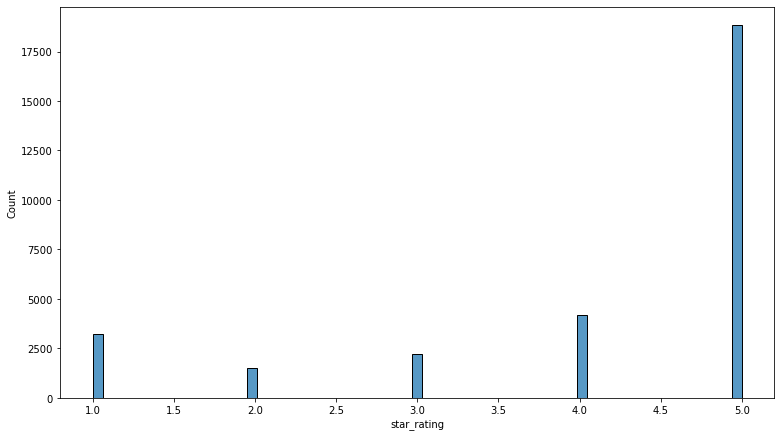

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (12.8,7.2))

sns.histplot(data['star_rating'])
plt.show()

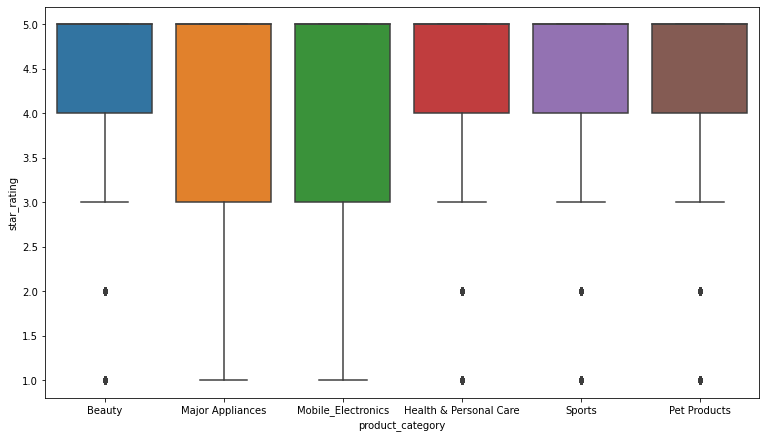

In [6]:
plt.figure(figsize= (12.8,7.2))
sns.boxplot(x='product_category', y='star_rating', data=data)
plt.show()

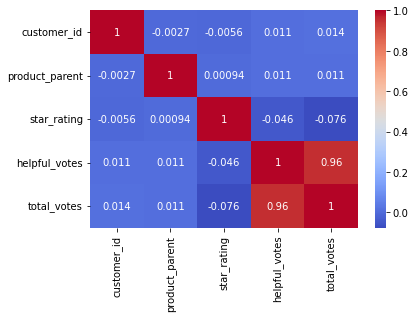

In [7]:
sns.heatmap(data.corr(),annot = True, cmap='coolwarm')
plt.show()

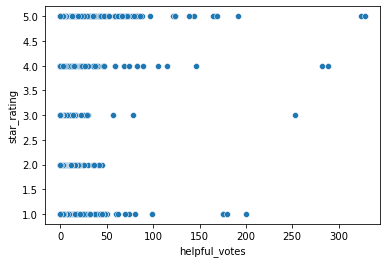

In [8]:
sns.scatterplot(x="helpful_votes",y = 'star_rating',data=data)
plt.show()

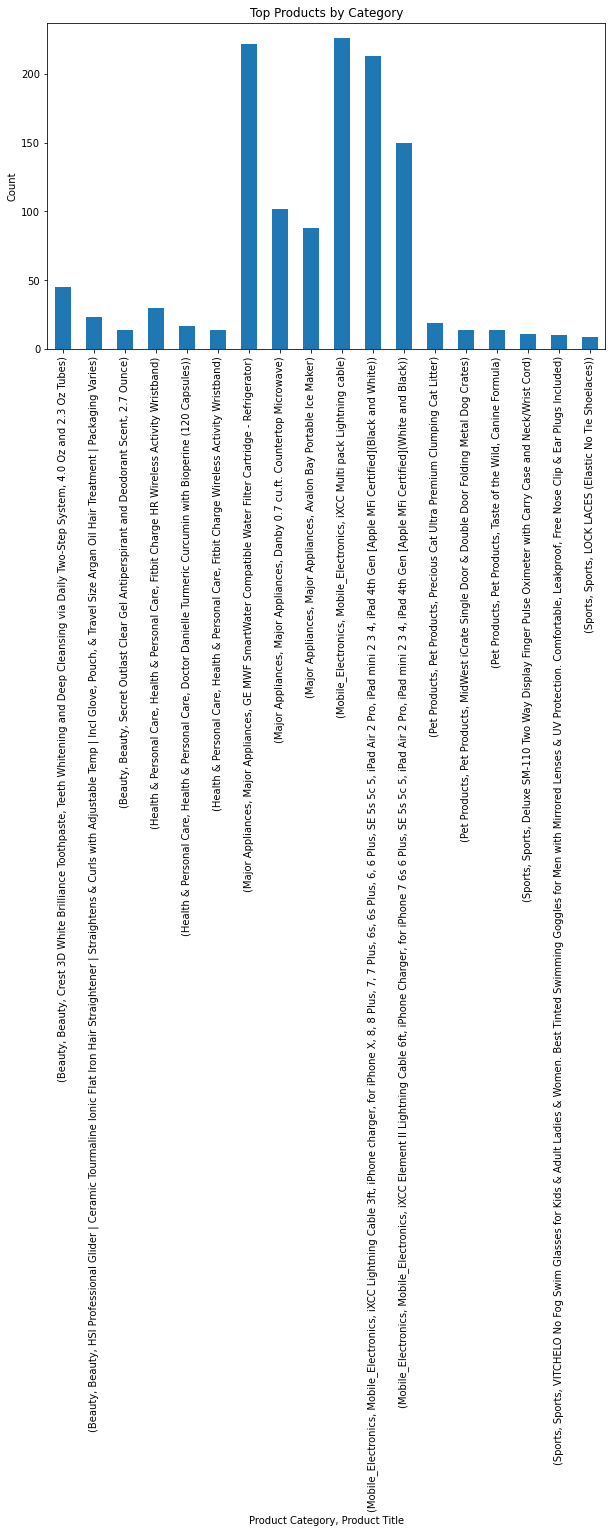

In [9]:
top_products_by_category = data.groupby('product_category')['product_title'].value_counts().groupby(level=0).nlargest(3)
fig, ax = plt.subplots(figsize=(10, 6))

top_products_by_category.plot(kind='bar')
ax.set_title('Top Products by Category')
ax.set_xlabel('Product Category, Product Title')
ax.set_ylabel('Count')

plt.show()

In [10]:
top_customers = data['customer_id'].value_counts().nlargest(10)
print(top_customers)

21959897.0    42
23208852.0    29
12612039.0    26
48872127.0    26
11599687.0    20
44877916.0    20
50657459.0    19
25414497.0    17
19397215.0    17
47120494.0    17
Name: customer_id, dtype: int64


In [11]:
avg_ratings = data.groupby('product_title')['star_rating'].mean().sort_values(ascending=False)
print(avg_ratings.head(10))

product_title
✮ LED Pulse Bluetooth 4.0 Full Spectrum Smart Speaker! Tribe Wireless Indoor Outdoor Speaker, Built In Microphone For Answering Calls / Loud & Crystal Clear Full Range HD Sound ✮ With 5x 360 Degree Light Modes Millions Of Light Patterns / AUX, SD, TF Card Support, / 8 Hour Playtime Li-ion Battery / ✮ One Year Warranty!    5.0
Marcy Utility Bench SB-350 – Adjustable 6 Position                                                                                                                                                                                                                                                                                  5.0
MapofBeauty Clip in Oblique Bang Hair Extensions Hair Accessorie                                                                                                                                                                                                                                                                    5.0
Ma

Cleaning of Text Data

In [12]:
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = ''.join(word for word in text if not word.isdigit())

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words and perform stemming
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]

    # Join the tokens back into a string
    clean_text = ' '.join(tokens)

    return clean_text

data['review_body'] = data['review_body'].apply(clean_text)

Convert star_rating to binary sentiment labels

In [13]:
# Select relevant columns
reviews = data[['review_body', 'star_rating', 'helpful_votes','total_votes']]

# Convert star_rating to binary sentiment labels
reviews['sentiment'] = np.where(reviews['star_rating'] >= 4, 1, 0)

# Apply weights based on helpful_votes
reviews['weight'] = reviews['helpful_votes'] / (reviews['total_votes'] + 1)

# Split the data into training and testing sets
train_data, test_data = train_test_split(reviews, test_size=0.3, random_state=42)

/var/folders/62/grj8ft516czf_wks6812mm0r0000gn/T/ipykernel_67816/2144490277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['sentiment'] = np.where(reviews['star_rating'] >= 4, 1, 0)
/var/folders/62/grj8ft516czf_wks6812mm0r0000gn/T/ipykernel_67816/2144490277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['weight'] = reviews['helpful_votes'] / (reviews['total_votes'] + 1)


In [14]:
# Preprocess the text data
max_vocab_size = 10000
max_seq_length = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(train_data['review_body'])
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data['review_body'])
train_padded = pad_sequences(train_sequences, maxlen=max_seq_length, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_data['review_body'])
test_padded = pad_sequences(test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

Load pretrained embedding (GloVe)

In [15]:
# Load the pretrained embedding
embedding_index = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create the embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Load pretrained embedding (Word2Vec)

In [16]:
# Load the pretrained embedding 2
import gensim.downloader as api
# Load the pre-trained Word2Vec model
wv = api.load('word2vec-google-news-300')
embedding_dim = 300
# Create the embedding matrix
max_vocab_size = min(max_vocab_size, len(word_index)) + 1
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < max_vocab_size:
        try:
            embedding_vector = wv.get_vector(word)
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Train CNN Model

In [18]:
#Define the CNN model 1
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train the model
model_1.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_1.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report1 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 17s 51ms/step - loss: 0.0751 - accuracy: 0.7908 - val_loss: 0.4048 - val_accuracy: 0.8216
Epoch 2/10
329/329 [==============================] - 16s 49ms/step - loss: 0.0501 - accuracy: 0.8305 - val_loss: 0.3924 - val_accuracy: 0.8252
Epoch 3/10
329/329 [==============================] - 16s 48ms/step - loss: 0.0268 - accuracy: 0.8522 - val_loss: 0.4794 - val_accuracy: 0.8279
Epoch 4/10
329/329 [==============================] - 16s 47ms/step - loss: 0.0128 - accuracy: 0.8660 - val_loss: 0.4968 - val_accuracy: 0.8163
Epoch 5/10
329/329 [==============================] - 16s 50ms/step - loss: 0.0068 - accuracy: 0.8705 - val_loss: 0.6092 - val_accuracy: 0.8321
Epoch 6/10
329/329 [==============================] - 16s 47ms/step - loss: 0.0072 - accuracy: 0.8667 - val_loss: 0.5774 - val_accuracy: 0.8229
Epoch 7/10
329/329 [==============================] - 16s 48ms/step - loss: 0.0047 - accuracy: 0.8678 - val_loss: 0.6592 - val_accuracy:

In [19]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_1.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

1/1 [==============================] - 0s 12ms/step
Statement: This product is great! | Sentiment: Positive | Sentiment Score: [0.75032943]
Statement: I don't really like the product | Sentiment: Negative | Sentiment Score: [0.06236084]
Statement: this product is shit | Sentiment: Negative | Sentiment Score: [0.2953609]
Statement: irritated my eyes and didn't work | Sentiment: Negative | Sentiment Score: [0.04919416]


In [20]:
# Define the CNN model 2
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(256, 5, activation='relu', padding='same'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_2.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_2.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_2.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report2 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 17s 51ms/step - loss: 0.0788 - accuracy: 0.7749 - val_loss: 0.4059 - val_accuracy: 0.8081
Epoch 2/10
329/329 [==============================] - 17s 53ms/step - loss: 0.0620 - accuracy: 0.8121 - val_loss: 0.4057 - val_accuracy: 0.8017
Epoch 3/10
329/329 [==============================] - 18s 53ms/step - loss: 0.0490 - accuracy: 0.8272 - val_loss: 0.3918 - val_accuracy: 0.8197
Epoch 4/10
329/329 [==============================] - 18s 53ms/step - loss: 0.0379 - accuracy: 0.8331 - val_loss: 0.4303 - val_accuracy: 0.8092
Epoch 5/10
329/329 [==============================] - 18s 53ms/step - loss: 0.0269 - accuracy: 0.8407 - val_loss: 0.5391 - val_accuracy: 0.8199
Epoch 6/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0221 - accuracy: 0.8429 - val_loss: 0.5313 - val_accuracy: 0.8119
Epoch 7/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0166 - accuracy: 0.8464 - val_loss: 0.5596 - val_accuracy:

In [21]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_2.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

1/1 [==============================] - 0s 14ms/step
Statement: This product is great! | Sentiment: Positive | Sentiment Score: [0.94597757]
Statement: I don't really like the product | Sentiment: Positive | Sentiment Score: [0.70869493]
Statement: this product is shit | Sentiment: Negative | Sentiment Score: [0.4698296]
Statement: irritated my eyes and didn't work | Sentiment: Negative | Sentiment Score: [0.16575633]


In [ ]:
# Define the CNN model 3
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='valid', strides=1, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_3.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_3.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_3.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report3 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 17s 51ms/step - loss: 0.1527 - accuracy: 0.7786 - val_loss: 0.4490 - val_accuracy: 0.8033
Epoch 2/10
329/329 [==============================] - 16s 48ms/step - loss: 0.0824 - accuracy: 0.8009 - val_loss: 0.4254 - val_accuracy: 0.8166
Epoch 3/10
329/329 [==============================] - 17s 52ms/step - loss: 0.0780 - accuracy: 0.8107 - val_loss: 0.4227 - val_accuracy: 0.8230
Epoch 4/10
329/329 [==============================] - 18s 53ms/step - loss: 0.0757 - accuracy: 0.8164 - val_loss: 0.4163 - val_accuracy: 0.8241
Epoch 5/10
329/329 [==============================] - 16s 50ms/step - loss: 0.0732 - accuracy: 0.8195 - val_loss: 0.4531 - val_accuracy: 0.7901
Epoch 6/10
329/329 [==============================] - 16s 50ms/step - loss: 0.0723 - accuracy: 0.8201 - val_loss: 0.4275 - val_accuracy: 0.8150
Epoch 7/10
329/329 [==============================] - 17s 53ms/step - loss: 0.0694 - accuracy: 0.8227 - val_loss: 0.4236 - val_accuracy:

In [ ]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_3.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

In [24]:
# Define the CNN model 4
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='valid', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='valid', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_4.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_4.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_4.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report4 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 13s 37ms/step - loss: 0.0796 - accuracy: 0.7790 - val_loss: 0.4119 - val_accuracy: 0.8177
Epoch 2/10
329/329 [==============================] - 12s 38ms/step - loss: 0.0601 - accuracy: 0.8167 - val_loss: 0.4181 - val_accuracy: 0.7857
Epoch 3/10
329/329 [==============================] - 12s 36ms/step - loss: 0.0454 - accuracy: 0.8248 - val_loss: 0.4137 - val_accuracy: 0.8176
Epoch 4/10
329/329 [==============================] - 12s 36ms/step - loss: 0.0280 - accuracy: 0.8386 - val_loss: 0.6404 - val_accuracy: 0.7456
Epoch 5/10
329/329 [==============================] - 12s 36ms/step - loss: 0.0164 - accuracy: 0.8473 - val_loss: 0.5983 - val_accuracy: 0.8157
Epoch 6/10
329/329 [==============================] - 12s 35ms/step - loss: 0.0107 - accuracy: 0.8529 - val_loss: 0.6645 - val_accuracy: 0.8084
Epoch 7/10
329/329 [==============================] - 12s 36ms/step - loss: 0.0072 - accuracy: 0.8525 - val_loss: 0.7441 - val_accuracy:

In [25]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_4.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

1/1 [==============================] - 0s 13ms/step
Statement: This product is great! | Sentiment: Positive | Sentiment Score: [0.5473492]
Statement: I don't really like the product | Sentiment: Positive | Sentiment Score: [0.5473492]
Statement: this product is shit | Sentiment: Positive | Sentiment Score: [0.5473492]
Statement: irritated my eyes and didn't work | Sentiment: Positive | Sentiment Score: [0.5473492]


In [26]:
# Define the CNN model 5
model_5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(256, 3, activation='relu', padding='same', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 3, activation='relu', padding='same', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_5.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_5.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_5.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report5 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 45s 136ms/step - loss: 0.0905 - accuracy: 0.7611 - val_loss: 0.5427 - val_accuracy: 0.7473
Epoch 2/10
329/329 [==============================] - 45s 137ms/step - loss: 0.0670 - accuracy: 0.8059 - val_loss: 0.3989 - val_accuracy: 0.8159
Epoch 3/10
329/329 [==============================] - 46s 141ms/step - loss: 0.0523 - accuracy: 0.8268 - val_loss: 0.4078 - val_accuracy: 0.8267
Epoch 4/10
329/329 [==============================] - 47s 142ms/step - loss: 0.0420 - accuracy: 0.8331 - val_loss: 0.4630 - val_accuracy: 0.8213
Epoch 5/10
329/329 [==============================] - 47s 144ms/step - loss: 0.0281 - accuracy: 0.8454 - val_loss: 0.6167 - val_accuracy: 0.8206
Epoch 6/10
329/329 [==============================] - 46s 139ms/step - loss: 0.0221 - accuracy: 0.8473 - val_loss: 0.8289 - val_accuracy: 0.8243
Epoch 7/10
329/329 [==============================] - 45s 137ms/step - loss: 0.0183 - accuracy: 0.8544 - val_loss: 0.7632 - val_ac

In [27]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_5.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

1/1 [==============================] - 0s 16ms/step
Statement: This product is great! | Sentiment: Positive | Sentiment Score: [0.7305974]
Statement: I don't really like the product | Sentiment: Positive | Sentiment Score: [0.72960764]
Statement: this product is shit | Sentiment: Positive | Sentiment Score: [0.71304923]
Statement: irritated my eyes and didn't work | Sentiment: Positive | Sentiment Score: [0.7100631]


In [28]:
# Define the CNN model 6
model_6 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, 5, activation='relu', padding='same', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, 5, activation='relu', padding='same', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 5, activation='relu', padding='same', strides=1),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_6.fit(train_padded, train_data['sentiment'], sample_weight=train_data['weight'], validation_data=(test_padded, test_data['sentiment']), epochs=10, batch_size=64)
# Evaluate the model on the test set
test_loss, test_acc = model_6.evaluate(test_padded, test_data['sentiment'], verbose=2)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Generate predictions on the test data
y_pred = (model_6.predict(test_padded) > 0.5).astype(int)

# Generate classification report
target_names = ['Negative', 'Positive']
report6 = classification_report(test_data['sentiment'], y_pred, target_names=target_names, output_dict=True)
print(classification_report(test_data['sentiment'], y_pred, target_names=target_names))

Epoch 1/10
329/329 [==============================] - 36s 109ms/step - loss: 0.0918 - accuracy: 0.7521 - val_loss: 0.4368 - val_accuracy: 0.7958
Epoch 2/10
329/329 [==============================] - 35s 106ms/step - loss: 0.0619 - accuracy: 0.8160 - val_loss: 0.4003 - val_accuracy: 0.8139
Epoch 3/10
329/329 [==============================] - 34s 105ms/step - loss: 0.0447 - accuracy: 0.8324 - val_loss: 0.4220 - val_accuracy: 0.8093
Epoch 4/10
329/329 [==============================] - 35s 107ms/step - loss: 0.0334 - accuracy: 0.8334 - val_loss: 0.6029 - val_accuracy: 0.7672
Epoch 5/10
329/329 [==============================] - 36s 111ms/step - loss: 0.0211 - accuracy: 0.8514 - val_loss: 0.6148 - val_accuracy: 0.8188
Epoch 6/10
329/329 [==============================] - 34s 105ms/step - loss: 0.0179 - accuracy: 0.8498 - val_loss: 0.7209 - val_accuracy: 0.8106
Epoch 7/10
329/329 [==============================] - 36s 111ms/step - loss: 0.0109 - accuracy: 0.8582 - val_loss: 0.7094 - val_ac

In [29]:
statements = ["This product is great!", "I don't really like the product","this product is shit","irritated my eyes and didn't work"]

# Convert the input statements to numerical data using the same tokenizer that was used during training
sequences = tokenizer.texts_to_sequences(statements)
X = pad_sequences(sequences, maxlen=100)

# Make predictions using the trained model
predictions = model_6.predict(X)

# Print the predictions
for i, statement in enumerate(statements):
    sentiment = "Positive" if predictions[i] > 0.5 else "Negative"
    print(f"Statement: {statement} | Sentiment: {sentiment} | Sentiment Score: {predictions[i]}")

1/1 [==============================] - 0s 13ms/step
Statement: This product is great! | Sentiment: Positive | Sentiment Score: [0.55978703]
Statement: I don't really like the product | Sentiment: Positive | Sentiment Score: [0.5556905]
Statement: this product is shit | Sentiment: Positive | Sentiment Score: [0.55316925]
Statement: irritated my eyes and didn't work | Sentiment: Positive | Sentiment Score: [0.5539643]


Classification Report

In [30]:
# Combine the classification reports into a single DataFrame
reports = [report1, report2,report3,report4,report5,report6]
df_reports = pd.DataFrame(reports,index=[1,2,3,4,5,6])
df_markdown = df_reports.to_markdown()
# Print the combined classification report
df_reports.style

,Negative,Positive,accuracy,macro avg,weighted avg
1,"{'precision': 0.5777377196935557, 'recall': 0.6208232445520581, 'f1-score': 0.5985060690943045, 'support': 2065}","{'precision': 0.8845303052647102, 'recall': 0.8648882480173036, 'f1-score': 0.8745990084572761, 'support': 6935}",0.808889,"{'precision': 0.731134012479133, 'recall': 0.7428557462846808, 'f1-score': 0.7365525387757903, 'support': 9000}","{'precision': 0.814138450908662, 'recall': 0.8088888888888889, 'f1-score': 0.8112510173701054, 'support': 9000}"
2,"{'precision': 0.5540829414279607, 'recall': 0.6276029055690072, 'f1-score': 0.5885558583106266, 'support': 2065}","{'precision': 0.8845518690887254, 'recall': 0.8496034607065609, 'f1-score': 0.8667255075022066, 'support': 6935}",0.798667,"{'precision': 0.7193174052583431, 'recall': 0.7386031831377841, 'f1-score': 0.7276406829064166, 'support': 9000}","{'precision': 0.8087276095754499, 'recall': 0.7986666666666666, 'f1-score': 0.8029010268821385, 'support': 9000}"
3,"{'precision': 0.5213963963963963, 'recall': 0.672639225181598, 'f1-score': 0.5874392049058997, 'support': 2065}","{'precision': 0.8933080808080808, 'recall': 0.8161499639509733, 'f1-score': 0.8529877175796851, 'support': 6935}",0.783222,"{'precision': 0.7073522386022386, 'recall': 0.7443945945662857, 'f1-score': 0.7202134612427924, 'support': 9000}","{'precision': 0.8079750109958442, 'recall': 0.7832222222222223, 'f1-score': 0.7920590866161998, 'support': 9000}"
4,"{'precision': 0.6185804962492787, 'recall': 0.5191283292978208, 'f1-score': 0.564507635597683, 'support': 2065}","{'precision': 0.8633548919774322, 'recall': 0.9046863734679164, 'f1-score': 0.8835375299253626, 'support': 6935}",0.816222,"{'precision': 0.7409676941133554, 'recall': 0.7119073513828686, 'f1-score': 0.7240225827615228, 'support': 9000}","{'precision': 0.8071927667353614, 'recall': 0.8162222222222222, 'f1-score': 0.8103378930601783, 'support': 9000}"
5,"{'precision': 0.584607794770597, 'recall': 0.5738498789346247, 'f1-score': 0.5791788856304985, 'support': 2065}","{'precision': 0.8737989387638032, 'recall': 0.8785868781542898, 'f1-score': 0.8761863675582399, 'support': 6935}",0.808667,"{'precision': 0.7292033667672001, 'recall': 0.7262183785444573, 'f1-score': 0.7276826265943692, 'support': 9000}","{'precision': 0.8074456373920287, 'recall': 0.8086666666666666, 'f1-score': 0.8080396508714858, 'support': 9000}"
6,"{'precision': 0.632086851628468, 'recall': 0.5075060532687651, 'f1-score': 0.5629868385710448, 'support': 2065}","{'precision': 0.8614818850449468, 'recall': 0.9120403749098774, 'f1-score': 0.8860404846956643, 'support': 6935}",0.819222,"{'precision': 0.7467843683367075, 'recall': 0.7097732140893213, 'f1-score': 0.7245136616333545, 'support': 9000}","{'precision': 0.8088484690443881, 'recall': 0.8192222222222222, 'f1-score': 0.8119176203348488, 'support': 9000}"


Generate new sentiment report using CNN model_3

In [31]:
# Set threshold levels
thresholds = [0.3, 0.5, 0.7, 0.9]

# Make predictions on the entire dataset
all_data_sequences = tokenizer.texts_to_sequences(data['review_body'])
all_data_padded = pad_sequences(all_data_sequences, maxlen=max_seq_length, padding='post', truncating='post')
all_data_predictions = model_3.predict(all_data_padded)

# Classify predictions into 1-5 star ratings using threshold levels
data['predicted_sentiment'] = pd.cut(all_data_predictions[:,0], bins=[-np.inf] + thresholds + [np.inf], labels=[1,2,3,4,5])

# Save the updated dataset as a new CSV file
data.to_csv('updated_reviews.csv', index=False)

938/938 [==============================] - 9s 10ms/step
